In [1]:
# import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
shape_data = pd.read_csv('Dataset/trafficsigns_dataset/shape_preprocessed.csv')

In [3]:
# Declare the number of classes in the dataset
OUTPUT_CLASSES_SHAPE = 5

In [4]:
def plot_pie_chart(data, target, ax):
    """Plots a pie chart of the target distribution in data"""
    data[target].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=False, startangle=90, ax=ax)

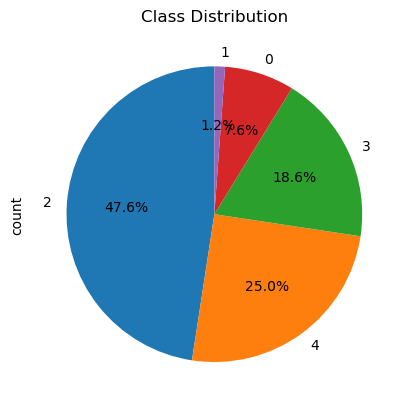

In [5]:
# A pie chart is used to visualize the class distribution
plot_pie_chart(data=shape_data, target='Shape', ax=None)
plt.title('Class Distribution')
plt.show()

Considerable class imbalance can be observed in the dataset. Hence we perform Stratified split to ensure that the distribution of classes is the same in both training and validation sets.

In [6]:
# split shape data into train, test, and validation sets
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(shape_data, test_size=0.2, random_state=42, stratify=shape_data['Shape'])
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data['Shape'])

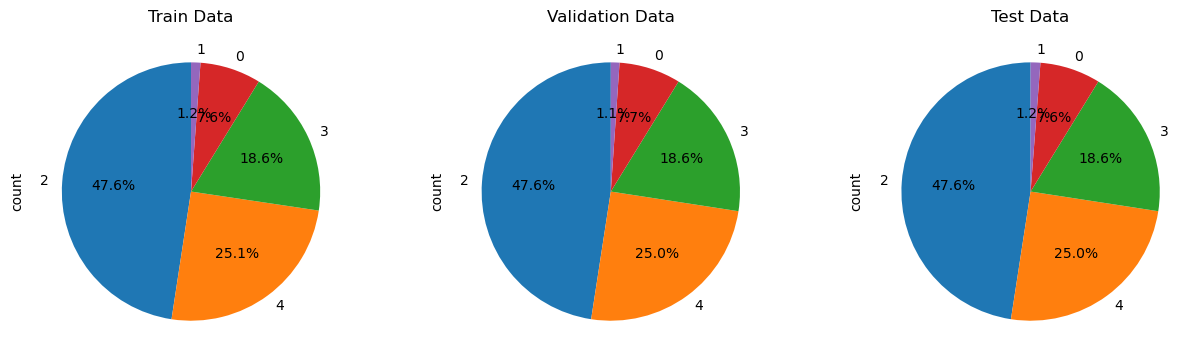

In [7]:
# Create a figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 3, figsize=(15, 15))  # Adjust the figsize

# Plot the train pie chart in the first subplot
plot_pie_chart(data=train_data, target='Shape', ax=axs[0])
axs[0].set_title('Train Data')

# Plot the validation pie chart in the second subplot
plot_pie_chart(data=val_data, target='Shape', ax=axs[1])
axs[1].set_title('Validation Data')

# Plot the test pie chart in the third subplot
plot_pie_chart(data=test_data, target='Shape', ax=axs[2])
axs[2].set_title('Test Data')
plt.subplots_adjust(wspace=0.3)  

# Display the plot
plt.show()

From the above figure it is clear that we have preserved the class distribution in training, validation and test sets.

In [8]:
# print the shape of the train, validation, and test sets
print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 2219, Val Data: 740, Test Data: 740


In [33]:
# convert the target column to string to work with keras ImageDataGenerator
train_data['Shape'] = train_data['Shape'].astype('str')
val_data['Shape'] = val_data['Shape'].astype('str')
test_data['Shape'] = test_data['Shape'].astype('str')

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# normalize pixel values and build a data generator
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# normalize pixel values and build a data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# choose 32 as the batch size
batch_size = 32

# train and validation generators
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Path",
        y_col="Shape",
        # All images are already 28x28 so retain the size
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Path",
        y_col="Shape",
        # All images are already 28x28 so retain the size
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,  # make sure you have a dataframe for test data
        directory='./',
        x_col="Path",
        y_col="Shape",
        # All images are already 28x28 so retain the size
        target_size=(28, 28),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical')

Found 2219 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


### Metric Selection
Considering that this is a multi-class calssification problem and the existing class imbalance in the dataset, we choose, classwise Precision, Recall, F1 Score and Support as the evaluation metrics. We also plot a confusion matrix to understand the model performance better.

Setup Diagnostics

In [18]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

### Baseline CNN
We choose LeNet-5 as the baseline architecture for this task, as this architecture was originally developed for recognising handwritten digits of 28x28 size. As our data is also 28x28, we belive this architecture should be a good fit as a baseline.

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


model_lenet_5 = Sequential([
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    Dense(units=OUTPUT_CLASSES_SHAPE)
])

/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


We have decided to follow the common LeNet-5 architecture
* Convolutional Layer 1: 6 filters of size 5x5 - This configuration is good for small grayscale images
* Convolutional Layer 2: 16 filters of size 5x5 - This is a common configuration
* Max Pooling Layer 1: 2x2 - To reduce the spatial dimensions of the image by half
* Dense Layer 1: 120 - Learns higher-level representations from the flattened convolutional features
* Dense Layer 2: 84 - This is also a common configuration
Relu activation function is used for all layers except the output layer as it introduces non-linearity and helps to learn more complex representations. We use softmax activation function in the output layer as this is a multi-class classification problem(as it outputs class probabilities that sum to 1)


/home/ashwin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


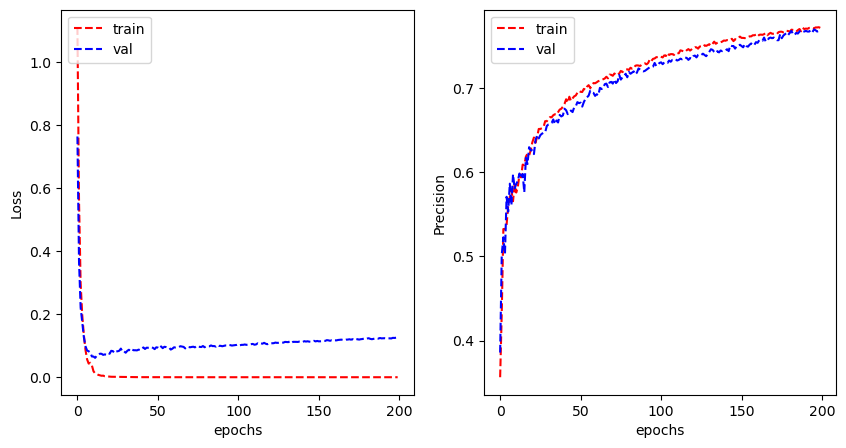

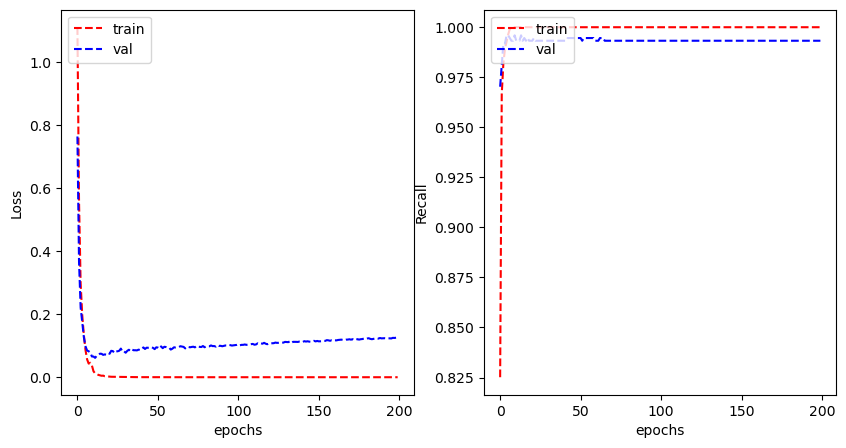

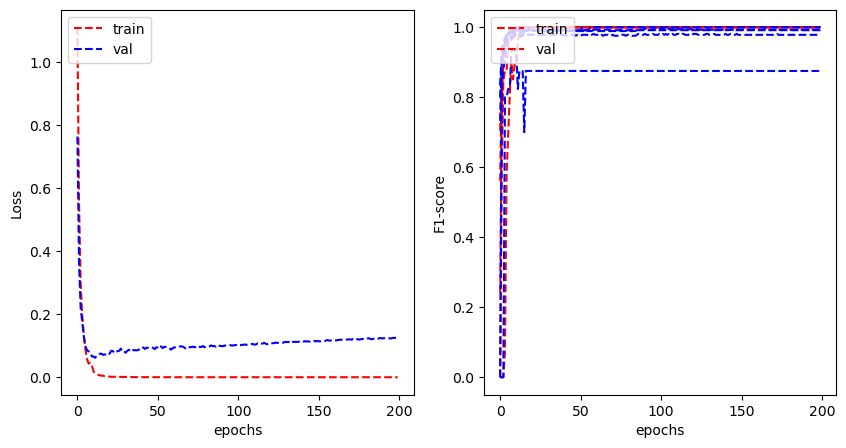

In [39]:
from tensorflow.keras.metrics import Precision, Recall, F1Score
import tensorflow as tf


# Compile the model
model_lenet_5.compile(optimizer='adam',
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                    metrics=["precision", "recall", "f1_score"])

# Train the model
history_VGG_1 = model_lenet_5.fit(train_generator,
                                          validation_data=validation_generator,
                                          epochs=200,
                                          verbose=0)

# Plot the learning curves
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'],
                    history_VGG_1.history['precision'], history_VGG_1.history['val_precision'],
                    metric_name='Precision')

plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'],
                    history_VGG_1.history['recall'], history_VGG_1.history['val_recall'],
                    metric_name='Recall')

plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'],
                    history_VGG_1.history['f1_score'], history_VGG_1.history['val_f1_score'],
                    metric_name='F1-score')

In [40]:
# Generate predictions
y_pred = model_lenet_5.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [41]:
# Get true labels
y_true = test_generator.classes

In [42]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

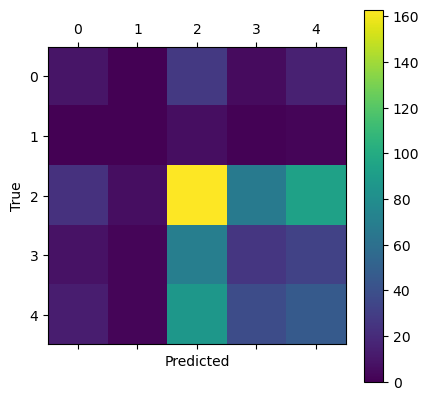

In [43]:
import matplotlib.pyplot as plt

# Display confusion matrix
plt.matshow(cm)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [44]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred_classes)

print(report)

              precision    recall  f1-score   support

           0       0.17      0.16      0.17        56
           1       0.00      0.00      0.00         9
           2       0.46      0.46      0.46       352
           3       0.19      0.19      0.19       138
           4       0.24      0.25      0.25       185

    accuracy                           0.33       740
   macro avg       0.21      0.21      0.21       740
weighted avg       0.33      0.33      0.33       740

